In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('./scripts/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gzip
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

import conf
import oncotree
from mutrate import KEYS, set_mutrate
from datasets_build import reformat, format_data
from plot import plot_auc_volcano, comparison_boxplot
conf.config_params()

tree = oncotree.Oncotree()
leaves = tree.get_ttypes('CANCER')

Loading observed mutations...
Loading in silico saturation mutagenesis...


# Extended Figure 7a

In [6]:
# Load data

fn = os.path.join(conf.output_boostdm, 'model_selection', 'eval_data.pickle.gz')
with gzip.open(fn, 'rb') as f:
    model_dict = pickle.load(f)
    
df_drivers = pd.read_csv(conf.drivers_path, sep='\t')

with gzip.open('./source-data/nondriver-observed-vs-non-observed.pickle.gz', 'rb') as g:
    nondrivers = pickle.load(g)

mutrate_table = pd.read_csv('./source-data/mutrate_table.tsv', sep='\t')

with gzip.open('./source-data/vectors_observed_all.pickle.gz', 'rb') as f:
    drivers = pickle.load(f)

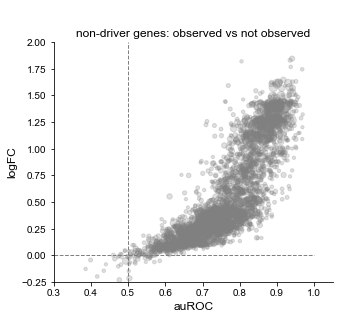

In [7]:
# Non-driver genes: observed vs not observed

res_nondriver, auc_nondriver = reformat(nondrivers)

plot_auc_volcano(res_nondriver, auc_nondriver, model_dict, df_drivers, './raw_plots/',
                 title='non-driver genes: observed vs not observed',
                 xlim=(0.3, 1.05),
                 ylim=(-0.25, 2.),
                 figsize=(5, 5),
                 density=False)

In [9]:
# Driver genes: observed versus not observed

res_driver, auc_driver = format_data(drivers, mutrate_table)
gene_ttype_specific = set(k for k, v in model_dict.items() if (k == v) and (k[0] in leaves))
res_driver = {k: v for k, v in res_driver.items() if k in gene_ttype_specific}
auc_driver = {k: v for k, v in auc_driver.items() if k in gene_ttype_specific}

100%|██████████| 249/249 [00:07<00:00, 33.99it/s]


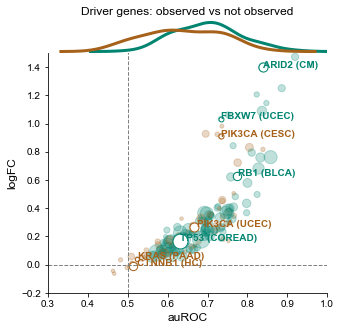

In [12]:
highlight_genes = [('TP53', 'COREAD'), ('PIK3CA', 'CESC'), ('ARID2', 'CM'), ('FBXW7', 'UCEC'), 
                   ('KRAS', 'PAAD'), ('PIK3CA', 'UCEC'), ('CTNNB1', 'HC'), ('RB1', 'BLCA')]
plot_auc_volcano(res_driver, auc_driver, model_dict,
                 df_drivers,
                 './raw_plots/',
                 title='Driver genes: observed vs not observed',
                 specific=True,
                 highlight_genes=highlight_genes,
                 xlim=(0.3, 1),
                 ylim=(-0.2, 1.5),
                 figsize=(5, 5),
                 density=True,
                 saveplot=True)

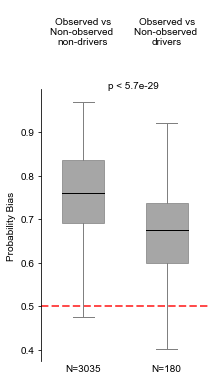

In [13]:
# Probability bias of non-driver genes compared to driver genes

legend1 = '\nObserved vs\nNon-observed \nnon-drivers'
legend2 = '\nObserved vs\nNon-observed \ndrivers'
fname = 'prob_bias_driver_vs_nondriver'

effective_auc_nondriver = {}
for k in res_nondriver:
    if len(res_nondriver[k][0]) >= 10:
        effective_auc_nondriver[k] = auc_nondriver[k]

comparison_boxplot(effective_auc_nondriver, auc_driver, legend1, legend2, fname)

# Extended Figure 7b

In [14]:
# Probability bias in driver genes: 1) driver vs passenger; 2) predicted observed vs non-observed

with gzip.open('./source-data/predicted-observed-vs-predicted-nonobserved.pickle.gz') as f:
    
    d = pickle.load(f)
    res_observed_nonobserved = d['zipped_mutrate']
    auc_observed_nonobserved = d['auc']
    
res_observed_nonobserved = {k: v for k, v in res_observed_nonobserved.items() if k in gene_ttype_specific}
auc_observed_nonobserved = {k: v for k, v in auc_observed_nonobserved.items() if k in gene_ttype_specific}

In [17]:
with gzip.open('./source-data/vectors_driver_vs_passenger_all.pickle.gz', 'rb') as f:
    driver_passenger = pickle.load(f)

driver_passenger = {k: v for k, v in driver_passenger.items() if k in gene_ttype_specific}

In [18]:
res_driver_passenger, auc_driver_passenger = format_data(driver_passenger, mutrate_table)

100%|██████████| 181/181 [00:07<00:00, 24.97it/s]


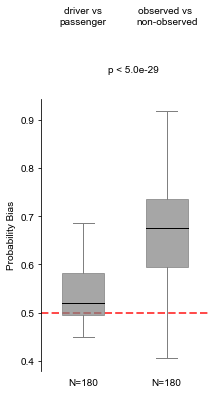

In [19]:
# Comparison boxplot

legend1 = 'driver vs\npassenger'
legend2 = 'observed vs \nnon-observed'
fname = 'driver-passenger_observed-non-observed'

comparison_boxplot(auc_driver_passenger, auc_observed_nonobserved, legend1, legend2, fname)